# Multiple Linear Regression - Raw Features

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

![mlr](https://miro.medium.com/max/1280/1*lJKFo3yyZaFIx4ET1dLmlg.png)

## Objectives

- Conduct multiple linear regressions in `statsmodels`
- Use standard scaling for linear regression for better interpretation
- Conduct linear regressions in `sklearn`

## Regression with Multiple Predictors

> It's all a bunch of dials

<img width='450px' src='images/dials.png'/>

The main idea here is pretty simple. Whereas, in simple linear regression we took our dependent variable to be a function only of a single independent variable, here we'll be taking the dependent variable to be a function of multiple independent variables.

## Expanding Simple Linear Regression

Our regression equation, then, instead of looking like $\hat{y} = mx + b$, will now look like:

$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1x_1 + ... + \hat{\beta}_nx_n$.

Remember that the hats ( $\hat{}$ ) indicate parameters that are estimated.

Is this still a best-fit *line*? Well, no. What does the graph of, say, z = x + y look like? [Here's](https://academo.org/demos/3d-surface-plotter/) a 3d-plotter. (Of course, once we get x's with subscripts beyond 2 it's going to be very hard to visualize. But in practice linear regressions can make use of dozens or even of hundreds of independent variables!)

## Closed-form Solution

Is it possible to calculate the betas by hand? Yes, a multiple regression problem still has a closed-form solution.

In a word, for a multiple linear regression problem where $X$ is the matrix of independent variable values and $y$ is the vector of dependent variable values, the vector of optimizing regression coefficients $\vec{b}$ is given by:

$\vec{b} = (X^TX)^{-1}X^Ty$.

We'll focus more directly on matrix mathematics later in the course, so don't worry if this equation is opaque to you. See [here](https://stattrek.com/multiple-regression/regression-coefficients.aspx) for a nice explanation and example.

## Confounding Variables

Suppose I have a simple linear regression that models the growth of corn plants as a function of the temperature of the ambient air. And suppose there is a noticeable positive correlation between temperature and plant height.

In [2]:
corn = pd.read_csv('data/corn.csv',
                  usecols=['temp', 'humid', 'height'])

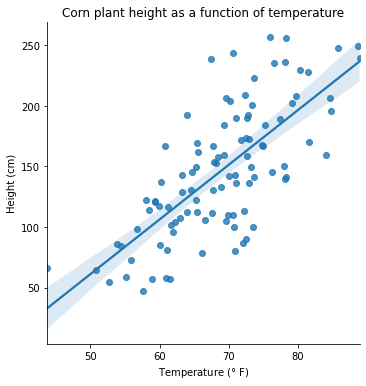

In [3]:
sns.lmplot(data=corn, x='temp', y='height')
plt.xlabel('Temperature ($\degree$ F)')
plt.ylabel('Height (cm)')
plt.title('Corn plant height as a function of temperature');

In [4]:
corn.head()

,temp,humid,height
0,58.086965,49.848304,122.222368
1,70.582087,22.855446,110.079666
2,75.868571,72.856834,256.812528
3,74.732376,38.907566,167.889601
4,77.384666,42.570524,188.914312


It seems that higher temperatures lead to taller corn plants. But it's hard to know for sure. One **confounding variable** might be *humidity*. If we haven't controlled for humidity, then it's difficult to draw conclusions.

One solution is to use **both features** in a single model.

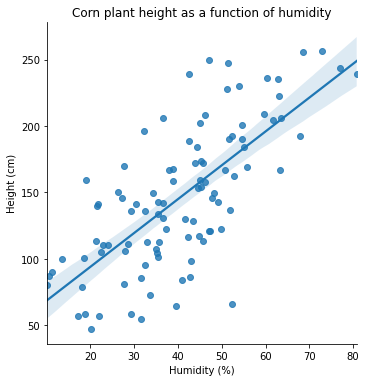

In [5]:
sns.lmplot(data=corn, x='humid', y='height')
plt.xlabel('Humidity (%)')
plt.ylabel('Height (cm)')
plt.title('Corn plant height as a function of humidity');

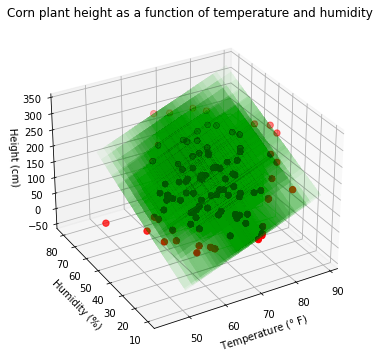

In [6]:
ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
ax.scatter(corn['temp'], corn['humid'], corn['height'],
           depthshade=True, s=40, color='#ff0000')
# create x,y
xx, yy = np.meshgrid(corn['temp'], corn['humid'])

# calculate corresponding z
z = 4.3825 * xx + 2.4693 * yy - 255.5434

# plot the surface
ax.plot_surface(xx, yy, z, alpha=0.01, color='#00ff00')

ax.view_init(30, azim=240)
ax.set_xlabel('Temperature ($\degree$ F)')
ax.set_ylabel('Humidity (%)')
ax.set_zlabel('Height (cm)')
plt.title('Corn plant height as a function of temperature and humidity');

One risk we run when adding more predictors to a model is that their correlations with the target may be nearly *collinear* with each other. This can make it difficult to determine which predictor is doing the heavy lifting. We shall explore this theme of **multicollinearity** in more depth in due course.

## Multiple Regression in `statsmodels`

Let's build a multiple regression with `statsmodels`. Let's start with a toy model:

In [7]:
centers = np.arange(1, 6)
preds = np.array([stats.norm(loc=center, scale=3).rvs(200) for center in centers]).T
preds_df = pd.DataFrame(preds, columns=[f'var{center}' for center in centers])

# Here we're setting the target _exactly_ equal to var1 + 2*var2 + 3*var3 + 4*var4 + 5*var5
target = preds_df['var1'] + 2*preds_df['var2'] + 3*preds_df['var3']\
    + 4*preds_df['var4'] + 5*preds_df['var5']
target_df = pd.DataFrame(target, columns=['target'])

In [8]:
df = pd.concat([preds_df, target_df], axis=1)

df.head()

,var1,var2,var3,var4,var5,target
0,1.780372,5.234057,7.309352,5.754895,6.217585,88.284049
1,-0.524369,5.079637,7.340808,6.599831,8.518424,100.648775
2,0.655911,1.255883,2.669717,2.754525,1.190233,28.146090
3,-4.002612,4.322841,6.417864,8.250375,2.016450,66.980410
4,1.539089,-1.958180,2.741031,5.950844,2.317382,41.236110


### Exercise

- Use `statsmodels.OLS()` to fit a linear regression model with five input variables to the target.
- Run the model summary. What are the betas? What value of $R^2$ did you get?

In [13]:
X = df.drop('target', axis=1)
y = df['target']
model = sm.OLS(endog=y, exog=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.438e+32
Date:                Tue, 05 Mar 2024   Prob (F-statistic):                        0.00
Time:                        15:46:28   Log-Likelihood:                          6068.5
No. Observations:                 200   AIC:                                 -1.213e+04
Df Residuals:                     195   BIC:                                 -1.211e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
var1           1.0000   3.53e-16   2.83e+15      0.000       1.000       1.000
var2           2.0000   3.79e-16   5.27e+15      0.000       2.000       2.000
var3           3.0000   3.49e-16    8.6e+15      0.000       3.000       3.000
var4           4.0000   3.12e-16   1.28e+16      0.000       4.000       4.000
var5           5.0000    3.1e-16   1.61e+16      0.000       5.000       5.000
==============================================================================
Omnibus:                        2.024   Durbin-Watson:                   1.480
Prob(Omnibus):                  0.363   Jarque-Bera (JB):                2.074
Skew:                           0.206   Prob(JB):                        0.355
Kurtosis:                       2.719   Cond. No.                         2.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<details>
    <summary>Answer</summary>
<code>X = df.drop('target', axis=1)
y = df['target']
model = sm.OLS(endog=y, exog=X).fit()
model.summary()</code>
    </details>

### Diamonds Dataset

In [ ]:
data = sns.load_dataset('diamonds').drop(['cut', 'color', 'clarity'], axis=1)

In [ ]:
data.head()

In [ ]:
X, y = data.drop('price', axis=1), data['price']

In [ ]:
model2 = sm.OLS(y, X).fit()
model2.summary()

<details>
    <summary><b>Remember that $R^2$ can be negative!</b> Click here for code that demonstrates this.</summary>

<code>bad_pred = np.mean(y) * np.ones(len(y))
worse_pred = (np.mean(y) + 1000) * np.ones(len(y))
print(metrics.r2_score(y, bad_pred))
print(metrics.r2_score(y, worse_pred))</code>
    </details>

## Wine Dataset 🍷

This dataset includes measurable attributes of different wines as well as their rated quality.

In [ ]:
wine = pd.read_csv('data/wine.csv')

wine.head()

In [ ]:
wine.info()

In [ ]:
wine.describe()

Imagine we want to attempt to estimate the perceived quality of a wine using these attributes.

In [ ]:
wine['quality'].value_counts()

In [ ]:
wine['red_wine'].value_counts()

### 🧠 **Knowledge Check**

> Why are we using "quality" as the dependent variable (target)? Would it make sense for another feature to be the target instead?

## Running the Regression

First, we'll separate the data into our predictors (X) and target (y)

In [ ]:
wine_preds = wine.drop('quality', axis=1)
wine_target = wine['quality']
wine_preds.head()

Now we can perform our (multiple) linear regression!

### Adding an Intercept ("Bias", "Constant") Term

When we were looking at *simple* linear regression, we generally assumed that there would be an intercept term ($\beta_0$) as well as a slope term ($\beta_1$). That will be no less true for multiple linear regression. So this time let's add an intercept term. We can do that by simply adding a column of ones to our dataset, and `statsmodels` has a shortcut for that.

In [ ]:
# use sm.add_constant() to add constant term/y-intercept
predictors = sm.add_constant(wine_preds)
predictors

In [ ]:
model = sm.OLS(wine_target, predictors).fit()

> All right! So we fitted our model! Take a look at the summary and look if you can understand the different parts.

In [ ]:
model.summary()

# Scaling - The Missing & Helpful Step

When you looked at the summary after we did the linear regression, you might have noticed something interesting.

Observing the coefficients, you might notice there are two relatively large coefficients and only one other is greater than 1.

## What's Going on Here?

In a word, it's useful to have all of our variables be on the same scale, so that the resulting coefficients are easier to interpret. If the scales of the variables are very different one from another, then some of the coefficients may end up on very large or very tiny scales.

This happens since the coefficients will effectively attempt to "shrink" or "expand" the features before factoring their importance to the model.

![](images/shrinkinator.jpeg)

This can make it more difficult for interpretation and identifying coefficients with the most "effect" on the prediction.

For more on this, see [this post](https://stats.stackexchange.com/questions/32649/some-of-my-predictors-are-on-very-different-scales-do-i-need-to-transform-them).

## A Solution: Standard Scaling

One solution is to *scale* our features. There are a few ways to do this but we'll focus on **standard scaling**.

When we do **standard scaling**, we're really scaling it to be the features' respective $z$-scores.

Benefits:

- This tends to make values relatively small (mean value is at $0$ and one standard deviation $\sigma$ from the mean is $1$).
- Easier interpretation: larger coefficients tend to be more influential

### Interpretation of Coefficients

Let's take a moment on this last point. Recall our interpretation of the linear regression coefficients (or betas): Suppose the coefficient for some predictor $x_1$ in a linear model is $\beta_1$. That's then to say that for a one-unit increase in the value of $x_1$, the model predicts an increase in the target of $\beta_1$ units.

But let's now focus on this idea of *units*. Suppose I build a model of liver tumor size (mm) that includes body mass (kg) and fingernail length ($\mu$m) as predictive features. And suppose further that the coefficients I find after fitting the model are:

- body mass: 0.1
- fingernail length: 0.1

Now: Which variable is more important to predicting liver tumor size? The coefficients have the same value, but they have very different interpretations in this context. The first coefficient tells us that, for every *kilogram* increase of body mass, I should expect an increase in liver tumor size of 0.1 mm. The second coefficient tells us that, for every *micron* increase of fingernal length, I should expect an increase in liver tumor size of 0.1 mm. Since microns are so small, fingernail length is likely more important than body mass.

Another thing to keep in mind here is that scaling recasts the values of a variable in terms of that variable's *standard deviation*. And so variables with greater spreads of values will typically be more important than variables with smaller spreads. (A variable with no spread can't explain much of anything!)

We can remove much of the guess work about which variables are more important by standardizing, since that **puts all variables on the same scale and in units of their standard deviations**.

We just have to remember to keep in mind this transformation when *interpreting* our coefficients. So suppose our variables' standard deviations are something like

- body mass: 20 kg
- fingernail length: 3000 $\mu$m

And suppose that after scaling we get coefficients that look like this:

- body mass: 2
- fingernail length: 300

Then we can say that for every increase in body mass of 20 kg, we can expect an increase in liver tumor size of 2 mm, and for every increase in fingernail length of 3000 $\mu$m, we can expect an increase in liver tumor size of 300 mm. And now these coefficients are comparable in the sense that they both reflect the variables' underlying spreads and distributions.

For more on this topic, see also [this blog post](https://www.analyticsvidhya.com/blog/2021/03/standardized-vs-unstandardized-regression-coefficient/).

Next time, let's *scale* our columns as $z$-scores first. 

##  Redoing with Standard Scaling

Let's try standard scaling the model with our wine dataset now.

In [ ]:
# We'll include all the columns for now.

wine_preds_scaled = (wine_preds - np.mean(wine_preds)) / np.std(wine_preds)

In [ ]:
wine_preds_scaled.describe()

In [ ]:
predictors = sm.add_constant(wine_preds_scaled)
model = sm.OLS(wine_target, predictors).fit()
model.summary()

> Compare how well this model did with the one before scaling. Does it perform any differently?

In [ ]:
# Notes here



### 🧠 **Knowledge Check**

> After standard scaling, what would it mean when all the $x_i$ are all $0$?

> And what does this mean for the constant term $\hat{\beta}_0$? Could we check this?

In [ ]:
wine_target.mean()